Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.
Описание колонок

    value – значения метрики
    experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Задача

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [1]:
import pandas as pd 
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab

from scipy.stats import norm

from tqdm.auto import tqdm

Считаем наши данные

In [2]:
hw_bootstrap = pd.read_csv(r'hw_bootstrap.csv', sep = ';')

In [3]:
hw_bootstrap.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
hw_bootstrap.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

Видим, что колонку "value" необходимо перевести в численный типа данных. Сделаем это.

In [5]:
hw_bootstrap.value = hw_bootstrap.value.str.replace(',', '.').astype(float)

In [6]:
hw_bootstrap.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

Для удобства создадим два датафрейма по типам "experimentVariant"

In [7]:
control = hw_bootstrap[hw_bootstrap.experimentVariant == 'Control']

In [8]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   value              500 non-null    float64
 2   experimentVariant  500 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 15.6+ KB


In [9]:
control.value.nunique()

500

In [10]:
treatment = hw_bootstrap[hw_bootstrap.experimentVariant == 'Treatment']

In [11]:
treatment.head()

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment


In [12]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 500 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   value              500 non-null    float64
 2   experimentVariant  500 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 15.6+ KB


In [13]:
treatment.value.nunique()

500

Видим, что полученные фреймы одинакового размера. Также видим, что все значения value в фреймах уникальны, что говорит о независимости выборок.

Посмотрим на распределения данных фреймов

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


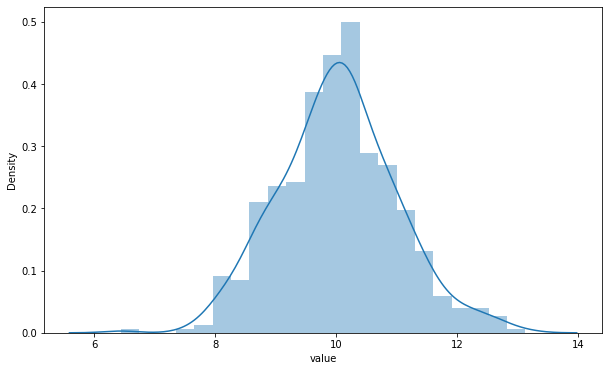

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(control.value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


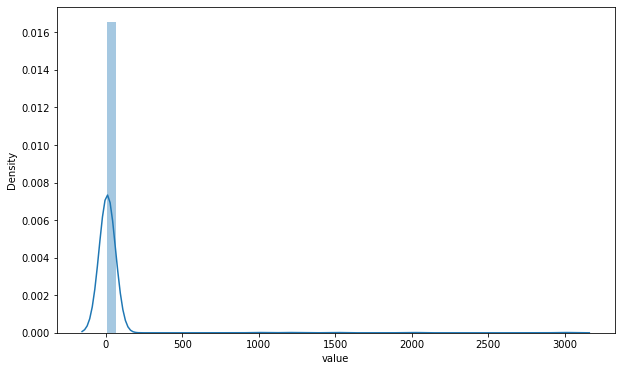

In [15]:
plt.figure(figsize=(10, 6))
sns.distplot(treatment.value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Значение теста')

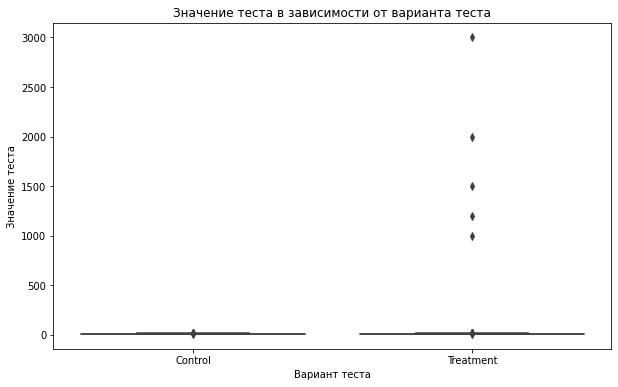

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(hw_bootstrap.experimentVariant, hw_bootstrap.value)
plt.title('Значение теста в зависимости от варианта теста')
plt.xlabel('Вариант теста')
plt.ylabel('Значение теста')

Видим, что распределение для "control" по графику является нормальным, а вот о "treatment" точно что-то сказать пока нельзя. Построим графики для логарифмированных значений.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


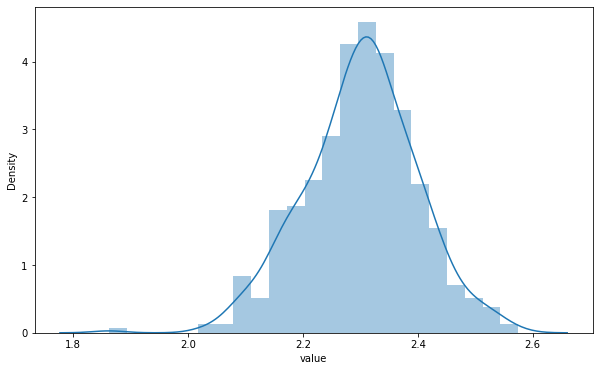

In [17]:
plt.figure(figsize=(10, 6))
sns.distplot(np.log(control.value))

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


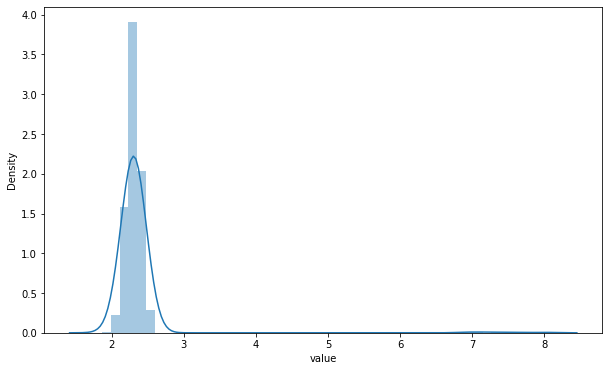

In [18]:
plt.figure(figsize=(10, 6))
sns.distplot(np.log(treatment.value))

Теперь и второе распределение больше напоминает нормальное, однако все равно присутствует большой хвост. Посмотрим на отсортированные значения для второго датафрейма.

In [19]:
treatment.sort_values('value').tail(10)

,Unnamed: 0,value,experimentVariant
719,720,12.598569,Treatment
863,864,12.663784,Treatment
794,795,12.728285,Treatment
695,696,12.817541,Treatment
671,672,13.130346,Treatment
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment
999,1000,3000.000000,Treatment


Видим, что в данных присутствуют значительные выбросы.
С этой точки зрения применение t-теста может быть затруднено.

Также проверим на нормальность наши данные с помощью normaltest и qqplot графиков

In [20]:
stats.normaltest(control.value)

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

In [21]:
stats.normaltest(treatment.value)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

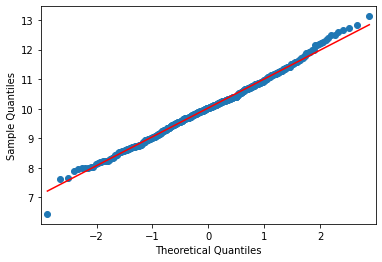

In [22]:
sm.qqplot(control.value, line = 's')
pylab.show()

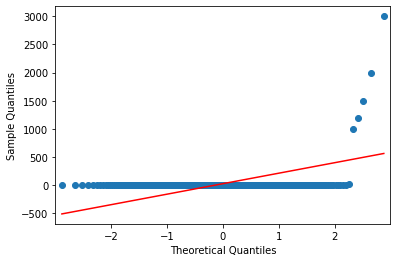

In [23]:
sm.qqplot(treatment.value, line = 's')
pylab.show()

Видим, что "control" имеет нормальное распределение, а "treatment" - нет.

Проверим дисперсии в наших группах

In [24]:
stats.levene(control.value, treatment.value)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

Видим, что p < 0.05 -> Отклоняем нулевую гипотезу о равенстве дисперсий.

Применим t-тест к нашим датафреймам (с точки зрения задания), однако с точки зрения проведенных проверок для данных двух групп его применять не следует. (Также применим для логарифмированных значений на всякий случай (хотя это ничего не даст))

In [25]:
stats.ttest_ind(control.value, treatment.value)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [26]:
stats.ttest_ind(np.log(control.value), np.log(treatment.value))

Ttest_indResult(statistic=-2.1379349959049563, pvalue=0.03276440163234999)

Видим, что и в случае изначальных величин, и в случае логарифмированных, p - значение < 0.05 -> отклоняем нулевую гипотезу и получаем, что различия в среднем заработке статистически значимы -> изменения в заработке с пользователя произошли.

Ради интереса применим t-тест, убрав из фрейма "treatment" столь аномальные выбросы.

In [27]:
treatment_1 = treatment.query('value < 1000')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


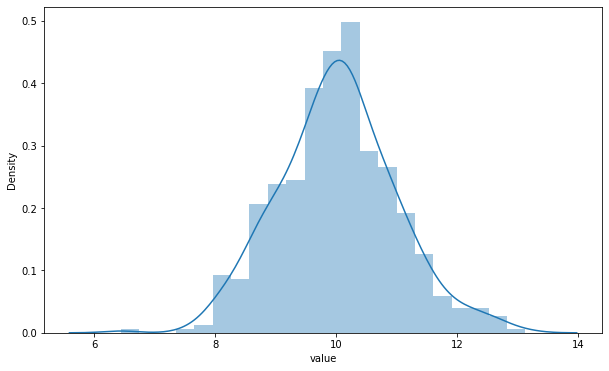

In [28]:
plt.figure(figsize=(10, 6))
sns.distplot(treatment_1.value)

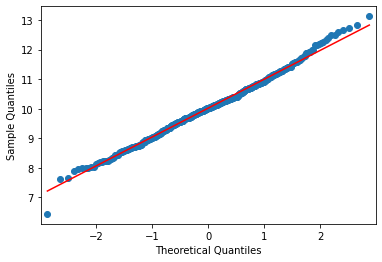

In [29]:
sm.qqplot(treatment_1.value, line = 's')
pylab.show()

In [30]:
stats.normaltest(treatment_1.value)

NormaltestResult(statistic=3.4264513588191425, pvalue=0.18028331749803517)

In [31]:
stats.levene(control.value, treatment_1.value)

LeveneResult(statistic=0.004297981921358907, pvalue=0.9477421313655946)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Значение теста')

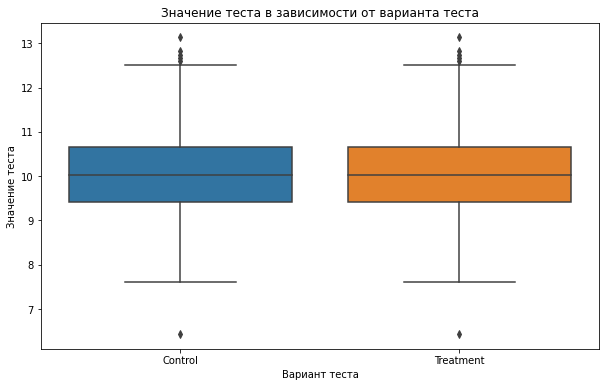

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(hw_bootstrap.query('value < 1000').experimentVariant, hw_bootstrap.query('value < 1000').value)
plt.title('Значение теста в зависимости от варианта теста')
plt.xlabel('Вариант теста')
plt.ylabel('Значение теста')

Видим, что в данном случае с точки зрения всех проверок у нас нет оснований не применять t-тест, сделаем это.

In [33]:
stats.ttest_ind(control.value, treatment_1.value)

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

p - значение много больше 0.05 -> принимаем нулевую гипотезу и получаем, что различия в среднем заработке статистически не значимы -> изменения в заработке с пользователя не произошли.

С точки зрения изначльных фреймов "control" и "treatment" и всех проведенных проверок лучшей идей было бы применить непараметрический тест - U-критерий Манна-Уитни. Данный метод позволяет работать с ненормальными распределениями и на него не оказывают влияния даже столь аномальные выбросы.

In [34]:
stats.mannwhitneyu(control.value, treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

При применении данного теста мы сразу можем сделать вывод о том, что мы принимаем нулевую гипотезу о статистической незначимости отличий в среднем заработке.

Ради интереса также применим данный критерий на измененный фрейм "treatment_1" с удаленными выбросами

In [35]:
stats.mannwhitneyu(control.value, treatment_1.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

В данном случае мы просто получим еще более стат значимый результат.

Последним шагом применим для сравнения данных фреймов метод bootstrap. Данный метод изначально может работать с ненормальными распределениями, не зависит от уникальности выборок. Однако, мы имеем аномальные выбросы в наших данных, поэтому bootstrap также может не очень хорошо работать, когда они присутствуют в выборке в связи с тем, что теоретически мы можем получать такие подвыборки, в которых получим, что постоянно будем доставать "значения из выбросов", а следовательно получим искаженный результат. Если изначальные данные искажены, то и результат работы bootstrap будет искажен.

In [36]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

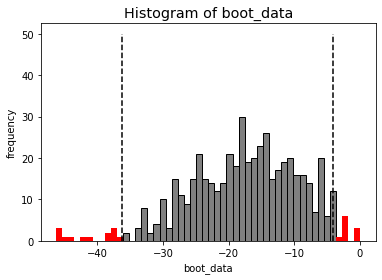

In [37]:
booted_data = get_bootstrap(control.value, treatment.value)

In [38]:
booted_data["p_value"] 

0.038363705563988965

Исходя из полученного графика и p-значения, мы также, как и в t-тесте можем сделать вывод о том, что мы отклоняем нулевую гипотезу и говорим, что стат различия присутствуют.

Однако, если мы применим bootstrap к фрейму с удаленными аномалями:

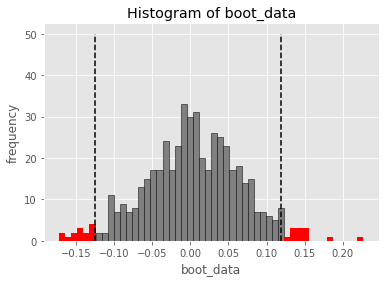

In [39]:
booted_data = get_bootstrap(control.value, treatment_1.value)

In [40]:
booted_data["p_value"] 

0.947178328424157

Получим, что принимаем нулевую гипотезу, и средний заработок не отличается.

# Выводы:

Проведя анализ примененных методов можно сказать следующее:

1. T-test может применятся при достаточном объеме выборок, при их независимости, нормальности распределений и гомоскедастичности, отсутствии аномальных выбросов.
2. U-критерий Манна-Уитни является непараметрическим аналогом t-критерия, поэтому его можно применять и в случае ненормального распределения и присутствия выбросов, однако для него важна незаисимость выборок.
3. Bootstrap может применяться в случае ненормального распределения, для него не важна независимость выборок, так как одно и тоже наблюдение может встречаться не один раз. Однако ограничением для него при этом является присутствие слишком аномальных значений, так как если изначальные данные искажены, то и результат работы bootstrap будет искажен.

При выборе метода для работы с представленными для работы данным в данной задаче и с учетом проведенной предобработки и исследования данных лучшим вариантом было бы сделать вывод о том, что в данном случае оптимальным вариантом было бы применение U-критерия Манна-Уитни.

В случае применения различных методов к исходным данным мы получаем близкие значения p-value для t-теста и bootstrap, но они противоположны p-value для U-критерия Манна-Уитни. Это происходит вследствие наличия слишком аномальных выбросов в данных.
Если же применить все три метода к видоизмененным данным (выброшенными аномальными значениями), то p-value для всех трех методов будет практически одинаковым.